# Linear Regression Using Multi-Layer Perceptron on Salary Prediction Dataset
## Author: Cody Ourique

In [66]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
import pathlib
import matplotlib.pyplot as plt
import tensorflow_addons
from tensorflow import keras
from tensorflow_addons.metrics import RSquare
from tensorflow.keras import layers


## Data Preprocessing

### Data Understanding

In [68]:
data = pd.read_csv("Salary Data.csv")
data.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [69]:
data.describe()

,Age,Years of Experience,Salary
count,373.000000,373.000000,373.000000
mean,37.431635,10.030831,100577.345845
std,7.069073,6.557007,48240.013482
min,23.000000,0.000000,350.000000
25%,31.000000,4.000000,55000.000000
50%,36.000000,9.000000,95000.000000
75%,44.000000,15.000000,140000.000000
max,53.000000,25.000000,250000.000000


In [70]:
data.dropna(inplace=True)
data.isna().sum()

Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64

### Feature Selection

,Education Level_Bachelor's,Education Level_Master's,Education Level_PhD,Years of Experience,Salary
0,1.0,0.0,0.0,5.0,90000.0
1,0.0,1.0,0.0,3.0,65000.0
2,0.0,0.0,1.0,15.0,150000.0
3,1.0,0.0,0.0,7.0,60000.0
4,0.0,1.0,0.0,20.0,200000.0


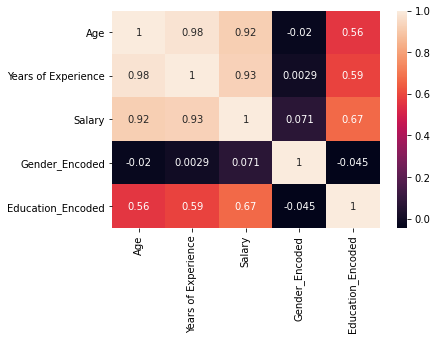

In [71]:
# Encode the categorical data
data['Gender_Encoded'] = data['Gender'].map({'Female': 0, 'Male': 1})
data.drop(columns=['Gender'], inplace=True)

# Create map for tenary encoding
education_mapping = {
    "Bachelor's": 0,
    "Master's": 1,
    "PhD": 2
}

data_non_numeric = data.select_dtypes(exclude=['number'])
# Drop Job Title due to complexity
data_non_numeric.drop(columns=['Job Title'], inplace=True)
data_encoded = pd.get_dummies(data_non_numeric, dtype = float)

# Perform ternary encoding for visualization only
data['Education_Encoded'] = data['Education Level'].map(education_mapping)
data.drop(columns=['Education Level'], inplace=True)

data_numeric = data.select_dtypes(include=['number'])
targets = pd.DataFrame(data["Salary"])

# Check for multicollinearity amongst numerical values
correlation_matrix = data_numeric.corr()
sns.heatmap(correlation_matrix, annot=True)

# Drop Age because it is highly correlated with Years of Experience and Years
# of Experience is more correlated with our target Salary 
data_numeric.drop(columns=['Age'], inplace=True)

# Drop gender because it is very loosley correlated to the dependent variable
data_numeric.drop(columns=['Gender_Encoded'], inplace=True)

# Drop Education_Encoded because we prefer the one hot encoding because this is linear regression problem
data_numeric.drop(columns=['Education_Encoded'], inplace=True)

# Concatenate the transformed data
data_final = pd.concat([data_encoded, data_numeric], axis=1)
data_final.head()

In [72]:
# train/test split
train = data_final.sample(frac=0.8, random_state=0)
test = data_final.drop(train.index)

# Save and drop the labels from the train and test data frame
train_labels = pd.DataFrame(train["Salary"])
train = train.drop(columns=["Salary"])
test_labels = pd.DataFrame(test["Salary"])
test = test.drop(columns=["Salary"])

# Add normilization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train))
print(normalizer.mean.numpy())

[[0.59731543 0.26174498 0.14093961 9.921141  ]]


Index(['Education Level_Bachelor's', 'Education Level_Master's',
       'Education Level_PhD', 'Years of Experience', 'Salary'],
      dtype='object')


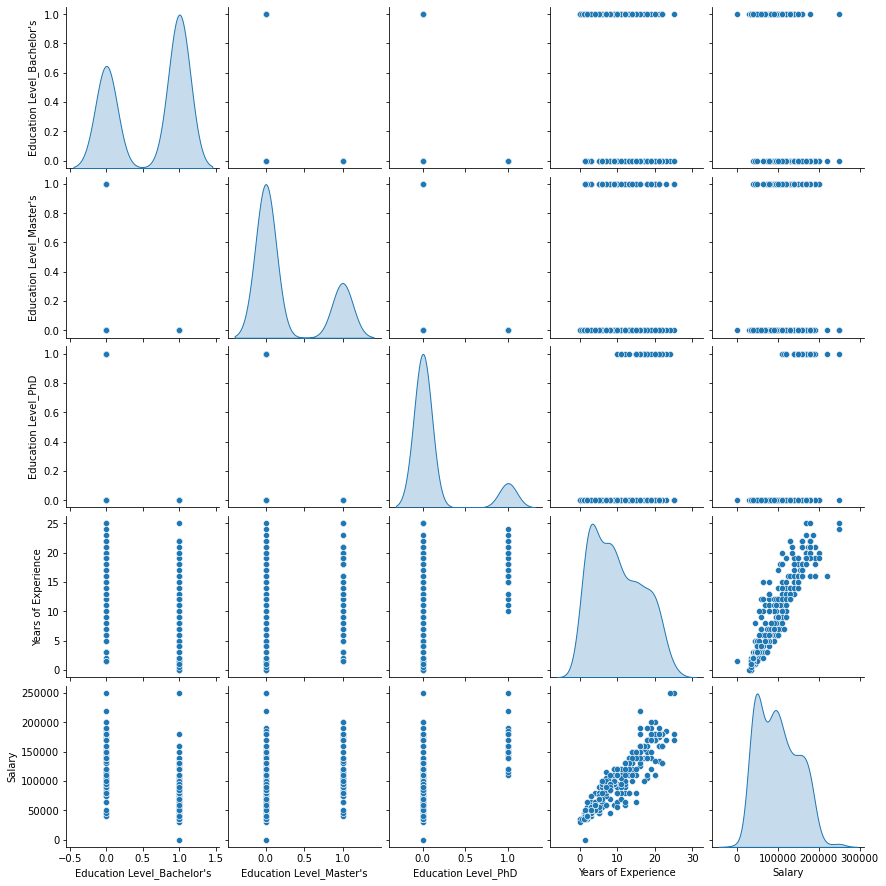

In [73]:
# Look at the correlation between variables 
sns.pairplot(data_final[data_final.columns], diag_kind="kde")
print(data_final.columns)

## Model Configuration

In [74]:
# Build the model
model = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu', input_shape=[len(train.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

model.compile(
    loss='mae',
    optimizer=optimizer,
    metrics=['mse','mae', RSquare()]
)

model.summary()

callback = keras.callbacks.EarlyStopping(monitor='loss' , patience=7)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normaliza  (None, 4)                 9         
 tion)                                                           
                                                                 
 dense_12 (Dense)            (None, 64)                320       
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6602 (25.79 KB)
Trainable params: 6593 (25.75 KB)
Non-trainable params: 9 (40.00 Byte)
___________________

In [75]:
# Test model on a batch of data
example_batch = train[:10]
example_batch = example_batch.to_numpy()
print(example_batch)
example_batch = tf.convert_to_tensor(example_batch)
example_result = model.predict(example_batch)
example_result

[[ 1.  0.  0.  2.]
 [ 1.  0.  0.  2.]
 [ 1.  0.  0.  3.]
 [ 0.  1.  0. 16.]
 [ 1.  0.  0.  8.]
 [ 0.  0.  1. 16.]
 [ 1.  0.  0.  4.]
 [ 0.  1.  0. 14.]
 [ 1.  0.  0.  2.]
 [ 0.  1.  0. 21.]]
1/1 [==============================] - 0s 120ms/step


array([[0.14486451],
       [0.14486451],
       [0.1119737 ],
       [0.11951758],
       [0.04108413],
       [0.0963694 ],
       [0.08809026],
       [0.1399196 ],
       [0.14486451],
       [0.05561578]], dtype=float32)

## Training the Model

In [76]:
history = model.fit(
    train, train_labels, epochs = 1000, validation_split=0.2, verbose=0, callbacks = [callback]
)

In [77]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mse,mae,r_square,val_loss,val_mse,val_mae,val_r_square,epoch
12,12068.916992,300979168.0,12068.916992,0.872664,15406.128906,387124448.0,15406.128906,0.817907,12
13,12349.288086,279521856.0,12349.288086,0.881742,17392.183594,466626624.0,17392.183594,0.780511,13
14,12090.281250,307110624.0,12090.281250,0.870070,12719.658203,291847392.0,12719.658203,0.862723,14
15,11330.707031,249668960.0,11330.707031,0.894372,13900.822266,354398304.0,13900.822266,0.833300,15
16,11334.579102,258887408.0,11334.579102,0.890472,13835.842773,347000032.0,13835.842773,0.836780,16


## Model Evaluation

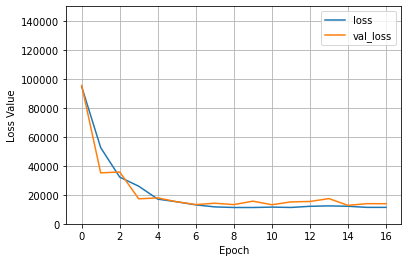

In [78]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0,150000])
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

In [79]:
loss, mse, mae, rs = model.evaluate(test, test_labels,verbose=0)

print(f'Testing set mean absolute error: {mae}\n')
print(f'Testing set mean squared error: {mse}\n')
print(f'Testing set loss: {loss}\n')
print(f'Testing set R squared score: {rs}')

Testing set mean absolute error: 13357.7861328125

Testing set mean squared error: 366067360.0

Testing set loss: 13357.7861328125

Testing set R squared score: 0.8322420120239258
